# Load necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Show the resource image to dreamify

The image shape = (512, 512, 3) ; dtype = uint8


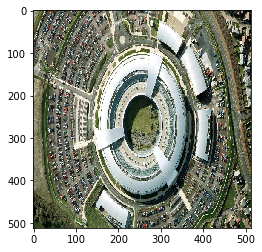

In [2]:
# Display a resource image
source_path = './samples/GCHQ.jpeg'
max_dim = 512                                 # set the max. dim of an image
input_img = cv2.imread(source_path)[:,:,::-1] # read the image and reverse channel order: BGR-->RGB
input_img_resize = cv2.resize(input_img, (max_dim, max_dim))
print('The image shape =', input_img_resize.shape, '; dtype =', input_img_resize.dtype) # Check the image shape
plt.imshow(input_img_resize)

# Prepare a pretrained model for feature extraction

In [3]:
# Load the pretrained InceptionV3 model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [4]:
# Define the loss function
def calc_loss(img, model):
    # Retrieve the activations to max. them
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

# Gradient ascent

In [5]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
    # The use of tf.function, see https://www.tensorflow.org/guide/concrete_function
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
                         tf.TensorSpec(shape=[], dtype=tf.int32),
                         tf.TensorSpec(shape=[], dtype=tf.float32),)
                )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            # This needs gradients relative to `img`
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
            # gradient ascent
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [6]:
deepdream = DeepDream(dream_model)

# Main loop

In [7]:
# Convert an image to uint8
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

In [8]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))
        plt.imshow(np.array(deprocess(img)), cmap='gray')
        plt.show()
        print ("Step {}, loss {}".format(step, loss))

    result = deprocess(img)
    fig = plt.gcf()
    fig.set_size_inches(8,10)
    plt.imshow(np.mean(np.array(result), axis=2), cmap='gray')
    plt.show()
    
    return np.array(result)

Tracing


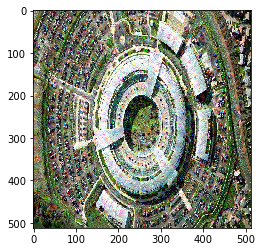

Step 100, loss 2.2450547218322754


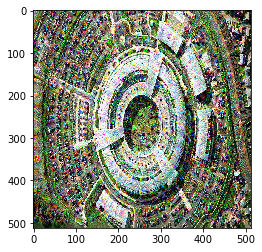

Step 200, loss 2.6937077045440674


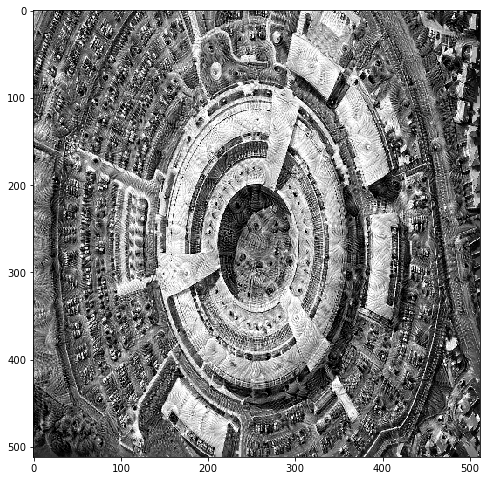

In [9]:
dream_img = run_deep_dream_simple(img=input_img_resize, steps=200, step_size=0.01)

# Taking it up an octave

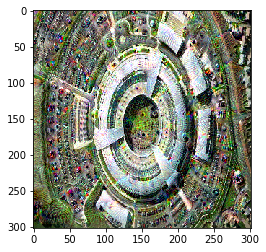

Step 100, loss 2.303478956222534


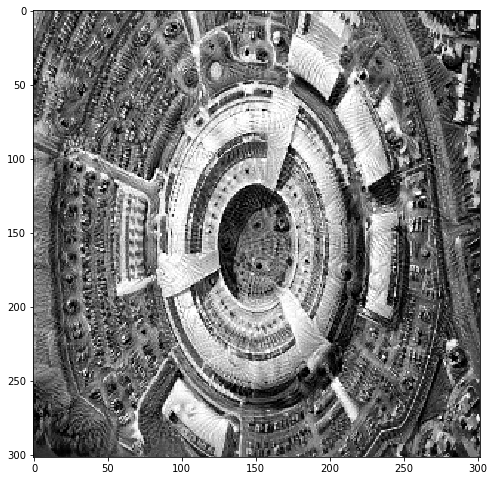

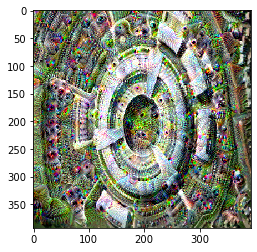

Step 100, loss 2.500723361968994


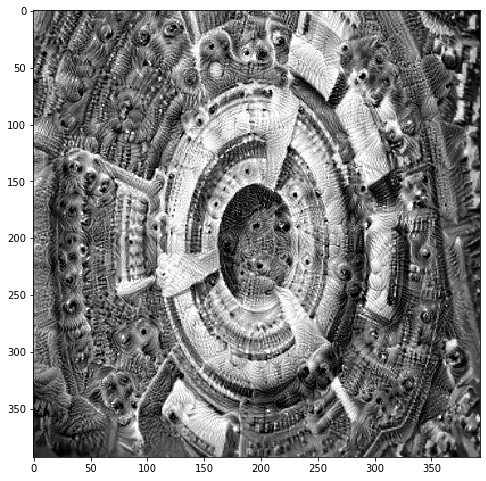

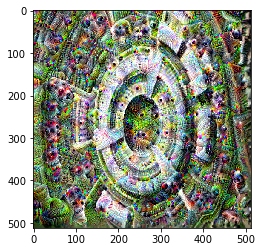

Step 100, loss 2.537919044494629


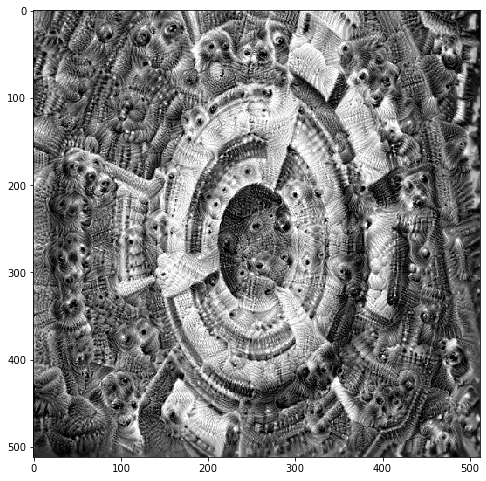

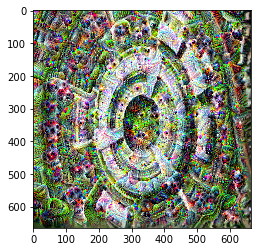

Step 100, loss 2.5185604095458984


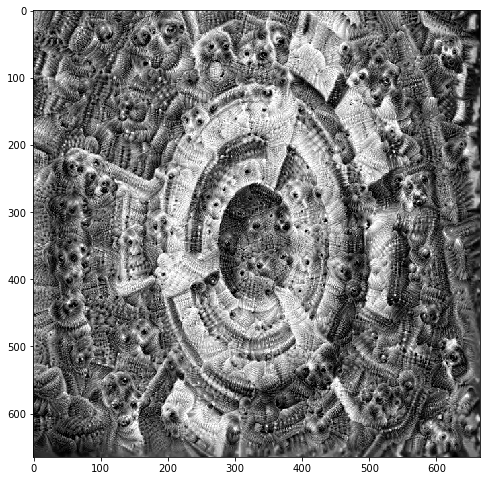

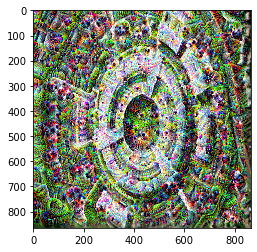

Step 100, loss 2.5149683952331543


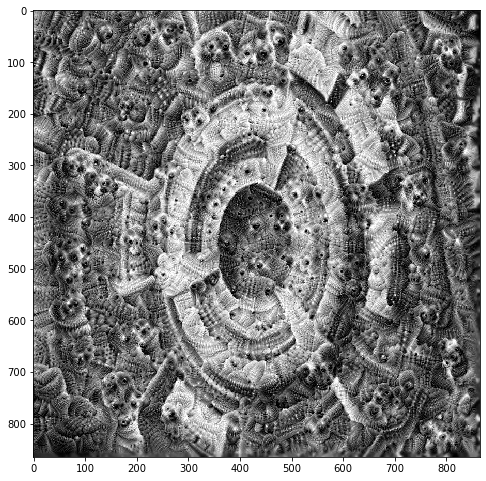

17.505669832229614

In [10]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(input_img_resize))
base_shape = tf.shape(img)[:-1]                     #(512,512)
float_base_shape = tf.cast(base_shape, tf.float32)  # shape values in terms of float32

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
    img = tf.image.resize(img, new_shape).numpy()
    img = run_deep_dream_simple(img=img, steps=100, step_size=0.01)

end = time.time()
end-start

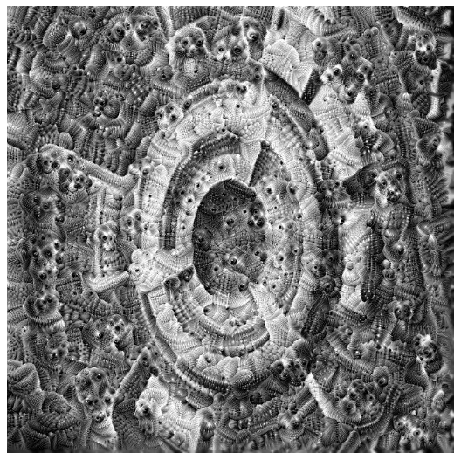

In [14]:
final_img = tf.image.resize(img, base_shape)
fig = plt.gcf()
fig.set_size_inches(8,10)
plt.axis('off')
plt.imshow(np.mean(np.array(final_img), axis=2), cmap='gray')
plt.savefig('./outputs/dream_GCHQ.jpg')
plt.show()